In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import tensorflow as tf
import keras
import numpy as np
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"

rho=32
train_gen = DataGenerator(train_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=(  #input
                    (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     # output
                    (tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32), 
                     tf.TensorSpec(shape=(8,),dtype=tf.float32))
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
for i in sample_output:
    print(i.shape)

reshuffling dataset
input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)
(8, 8)


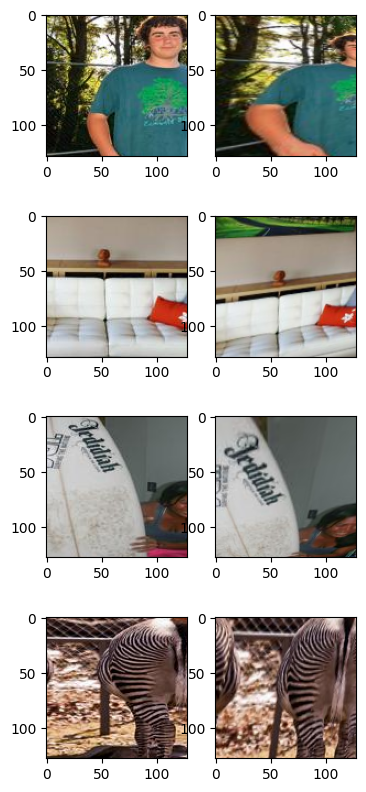

In [13]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [14]:
# a = tf.Variable(1.0)
# tf.debugging.check_numerics(a, message='')

# b = tf.Variable(np.nan)
# try:
#   tf.debugging.check_numerics(b, message='Checking b')
#   print("bbbb")
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message
#   print(e.message)

# c = tf.Variable(np.inf)
# try:
#   tf.debugging.check_numerics(c, message='Checking c')
# except Exception as e:
#   assert "Checking c : Tensor had Inf values" in e.message

In [17]:
import sys
# define loss and metrics
def loss_img(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) 
    # notice 1-norm is used


def metric_abs(y_true, y_pred):
    """computes the mean difference between predicted and actual corner shift
    values in x and y direction

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

# build new model with TensorDLT and STN added
homography_net = model_v2()
# homography_net.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8
h4pt_batch = tf.clip_by_value(h4pt_batch,clip_value_min=-rho,clip_value_max=rho)

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

class FullModel(keras.Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs=inputs, outputs=outputs)
        self.loss_tracker = keras.metrics.MeanAbsoluteError(name='mae_loss')
        self.metric_h4pt = keras.metrics.MeanAbsoluteError(name='mae_h4pt')
        self.loss_tracker_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_loss')
        self.metric_h4pt_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_h4pt')

    # @tf.function
    def train_step(self, data):
        data_in, data_out = data
        with tf.GradientTape() as tape:
            model_out = self(data_in, training=True)
            loss = tf.reduce_mean(keras.losses.mean_absolute_error(
                                                    y_true=data_out[0],
                                                    y_pred=model_out[0]))

        grads = tape.gradient(loss, self.trainable_variables)

        # check if grad has nan, if so simply return
        skip = False
        for g in grads:
            try:
                tf.debugging.check_numerics(g, message='Checking grad')
            except Exception as e:
                tf.print("==================== nan found ====================",)
                skip = True
                break

        if skip is False:
            # do gradient update
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

            self.loss_tracker.update_state(data_out[0], model_out[0])
            self.metric_h4pt.update_state(data_out[-1], model_out[-1])

        return {"mae_loss": self.loss_tracker.result(),
            "mae_h4pt": self.metric_h4pt.result()}
    
    def test_step(self, data):
        data_in, data_out = data
        model_out = self(data_in, training=False)

        self.loss_tracker_val.update_state(data_out[0], model_out[0])
        self.metric_h4pt_val.update_state(data_out[-1], model_out[-1])

        return {"val_mae_loss": self.loss_tracker_val.result(),
            "val_mae_h4pt": self.metric_h4pt_val.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.metric_h4pt]
    
full_model = FullModel(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], 
                        outputs=[img_pred,h4pt_batch])

# rename output layers
full_model.layers[2]._name = 'h4pt_output'
full_model.layers[-1]._name = 'img_output'
full_model.summary()

# full_model.load_weights("./chkpt_weight/checkpoint_mdl_unsupervised")

# compile model
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3,clipvalue=0.01),
                   run_eagerly=True)


new init
checking nan
Model: "full_model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 h4pt_output (Functional)    (None, 8)                    3777980   ['input_18[0][0]',            
                                                          0          'input_19[0][0]']            
                                                                                                  
 tf.clip_by_value_10 (TFOpL  (None, 8)                    0      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[  3. -14.  -1. -27. -23.  28.  32.  24.]
 [ 27.   6.  22.   0. -13. -13.  22.   0.]
 [  8. -19.  18.  22.   7. -30.  -6.  19.]
 [ -9.  27.  32.   8.  18. -32.  -7.  -6.]
 [ 21.   8. -32.   5. -31.  25.  15. -31.]
 [  8.   6. -29.  27.  -8. -25. -32. -16.]
 [-30.  11. -15.  20. -13.  32.  15.  10.]
 [-22.  -4. -17.   8. -28.  -5. -17.   2.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[  6. -11.  -1. -20. -17.  29.  15.  14.]
 [ 32.   6.  29.   4. -16.  -7.  26.  13.]
 [ 24. -17.  10.  16.   3. -22.   7.  14.]
 [ -4.  28.  32.  20.  24. -18. -16.  -3.]
 [ 17.   7. -32. -14. -32.   6.  -1.  -4.]
 [  5.   0. -12.   4.  17. -32. -23. -32.]
 [-32.  17. -19.  11. -14.  18.  23. -22.]
 [-21.   1. -21.  -4. -16.  -1. -17.  -7.]], shape=(8, 8), dtype=float32)


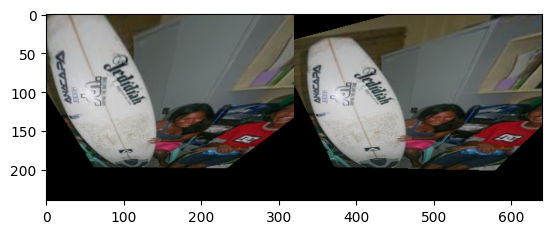

In [24]:
import numpy as np
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
assert(sample_model_output[0].shape==sample_input[2].shape)
print(sample_output[-1])
print(tf.round(sample_model_output[1]))

import matplotlib.pyplot as plt
plt.imshow(np.hstack( ((sample_output[0][2,:,:,:]).numpy(),
                      (sample_model_output[0][2,:,:,:]).numpy())
            )
           )


In [19]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))

# reduce learning rate when performance plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae_loss',
                                                factor=0.2,
                                                patience=3,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=3)

# save check points 
checkpoint_filepath = './chkpt_weight/checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='mae_loss',
                                                mode='min',
                                                save_best_only=True,
                                                verbose=True
                                                )

# start training
history = full_model.fit(train_ds,
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds,
                         validation_steps=int(np.floor(1000/batch_size)),
                         validation_freq=1,
                         verbose=True,
                         callbacks=[reduce_lr, checkpoint_callback])

Epoch 1/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1419 - mae_h4pt: 10.3366reshuffling dataset
reshuffling dataset

Epoch 1: mae_loss improved from inf to 0.14193, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 209s 323ms/step - mae_loss: 0.1419 - mae_h4pt: 10.3366 - val_val_mae_loss: 0.1475 - val_val_mae_h4pt: 11.2318 - lr: 4.0000e-05
Epoch 2/100
338/625 [===============>..............] - ETA: 1:26 - mae_loss: 0.1406 - mae_h4pt: 10.2153

2024-03-01 11:57:19.430301: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


625/625 [==============================] - ETA: 0s - mae_loss: 0.1413 - mae_h4pt: 10.2448reshuffling dataset

Epoch 2: mae_loss improved from 0.14193 to 0.14135, saving model to ./chkpt_weight/checkpoint_mdl_unsupervised
625/625 [==============================] - 202s 323ms/step - mae_loss: 0.1413 - mae_h4pt: 10.2448 - val_val_mae_loss: 0.1473 - val_val_mae_h4pt: 11.1942 - lr: 4.0000e-05
Epoch 3/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1414 - mae_h4pt: 10.2481reshuffling dataset

Epoch 3: mae_loss did not improve from 0.14135
625/625 [==============================] - 189s 303ms/step - mae_loss: 0.1414 - mae_h4pt: 10.2481 - val_val_mae_loss: 0.1470 - val_val_mae_h4pt: 11.1618 - lr: 4.0000e-05
Epoch 4/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1421 - mae_h4pt: 10.3289reshuffling dataset

Epoch 4: mae_loss did not improve from 0.14135
625/625 [==============================] - 185s 297ms/step - mae_loss: 0.1421 - mae_h4pt: 10.3289 - v

2024-03-01 12:27:10.275668: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


625/625 [==============================] - ETA: 0s - mae_loss: 0.1424 - mae_h4pt: 10.3590reshuffling dataset

Epoch 12: mae_loss did not improve from 0.14135
625/625 [==============================] - 168s 269ms/step - mae_loss: 0.1424 - mae_h4pt: 10.3590 - val_val_mae_loss: 0.1450 - val_val_mae_h4pt: 10.8973 - lr: 1.6000e-06
Epoch 13/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1427 - mae_h4pt: 10.3404reshuffling dataset

Epoch 13: mae_loss did not improve from 0.14135
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1427 - mae_h4pt: 10.3404 - val_val_mae_loss: 0.1448 - val_val_mae_h4pt: 10.8698 - lr: 1.6000e-06
Epoch 14/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1418 - mae_h4pt: 10.2572reshuffling dataset

Epoch 14: mae_loss did not improve from 0.14135
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1418 - mae_h4pt: 10.2572 - val_val_mae_loss: 0.1446 - val_val_mae_h4pt: 10.8442 - lr: 1

2024-03-01 13:02:28.791518: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


625/625 [==============================] - ETA: 0s - mae_loss: 0.1413 - mae_h4pt: 10.1922reshuffling dataset

Epoch 24: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1413 - mae_h4pt: 10.1922 - val_val_mae_loss: 0.1429 - val_val_mae_h4pt: 10.6234 - lr: 1.0000e-06
Epoch 25/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1413 - mae_h4pt: 10.2539reshuffling dataset

Epoch 25: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1413 - mae_h4pt: 10.2539 - val_val_mae_loss: 0.1427 - val_val_mae_h4pt: 10.6035 - lr: 1.0000e-06
Epoch 26/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1421 - mae_h4pt: 10.3091reshuffling dataset

Epoch 26: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1421 - mae_h4pt: 10.3091 - val_val_mae_loss: 0.1425 - val_val_mae_h4pt: 10.5850 - lr: 1

2024-03-01 13:12:06.970975: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


625/625 [==============================] - ETA: 0s - mae_loss: 0.1423 - mae_h4pt: 10.3089reshuffling dataset

Epoch 28: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1423 - mae_h4pt: 10.3089 - val_val_mae_loss: 0.1423 - val_val_mae_h4pt: 10.5533 - lr: 1.0000e-06
Epoch 29/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1414 - mae_h4pt: 10.3024reshuffling dataset

Epoch 29: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1414 - mae_h4pt: 10.3024 - val_val_mae_loss: 0.1422 - val_val_mae_h4pt: 10.5351 - lr: 1.0000e-06
Epoch 30/100
625/625 [==============================] - ETA: 0s - mae_loss: 0.1412 - mae_h4pt: 10.2915reshuffling dataset

Epoch 30: mae_loss did not improve from 0.14114
625/625 [==============================] - 169s 270ms/step - mae_loss: 0.1412 - mae_h4pt: 10.2915 - val_val_mae_loss: 0.1421 - val_val_mae_h4pt: 10.5198 - lr: 1

2024-03-01 13:20:55.412069: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


416/625 [==================>...........] - ETA: 51s - mae_loss: 0.1416 - mae_h4pt: 10.3004

2024-03-01 13:21:36.319173: E tensorflow/core/kernels/check_numerics_op.cc:293] abnormal_detected_host @0x7fef5a800000 = {1, 0} Checking grad


625/625 [==============================] - ETA: 0s - mae_loss: 0.1418 - mae_h4pt: 10.2694reshuffling dataset

Epoch 31: mae_loss did not improve from 0.14114
625/625 [==============================] - 176s 281ms/step - mae_loss: 0.1418 - mae_h4pt: 10.2694 - val_val_mae_loss: 0.1419 - val_val_mae_h4pt: 10.5045 - lr: 1.0000e-06
Epoch 32/100
 16/625 [..............................] - ETA: 2:53 - mae_loss: 0.1394 - mae_h4pt: 9.7770

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


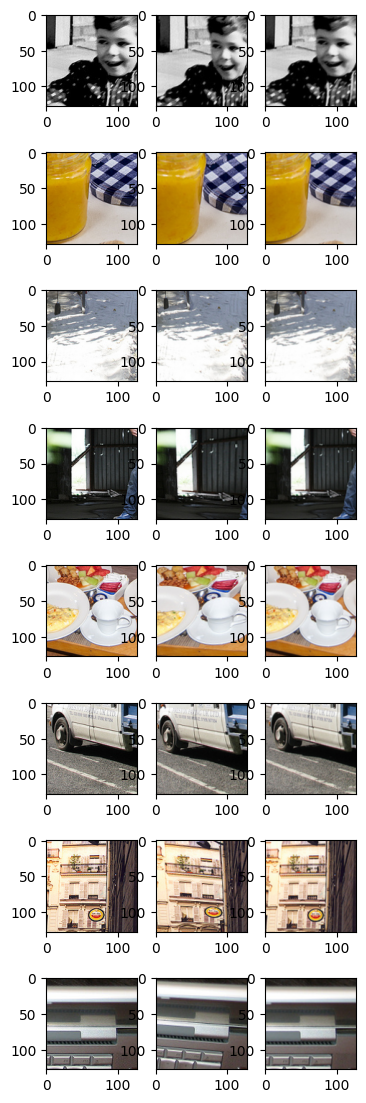

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()